## Instalacja oraz import pakietów

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cv2
import pywt
import h5py
import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import IPython.display as ipd

from skimage.feature import hog
from skimage import io, color

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

Poniżej znajduje się kilka pomocnych funkcji, które w tym notatniku będą używane wielokrotnie.

In [2]:
def display_images_in_row(imgs, title, figsize=(12, 12), cmap='gray'):
  fig = plt.figure(figsize=figsize)
  st = fig.suptitle(title, fontsize="x-large")

  idx = 1
  for img in imgs:
    ax = fig.add_subplot(len(imgs), len(imgs), idx)
    ax.imshow(img, cmap=cmap)
    idx += 1

  fig.tight_layout()
  st.set_y(0.95)
  fig.subplots_adjust(top=0.90)

In [3]:
colors_map =  {
    '0' : [76, 146, 195],
    '1' : [131, 187, 225],
    '2' : [204, 234, 255],
    '3' : [255, 153, 62],
    '5' : [255, 221, 191],
    '6' : [44, 160, 44],
    '7' : [106, 208, 106],
    '8' : [191, 255, 191],
    '9' : [214, 39, 40],
}

In [4]:
def plot_embeddings_2D(embeddings, targets, colors_map):
  fig = plt.figure(figsize = (12, 12))
  ax = fig.add_subplot(111)

  for label in colors_map:
      indices = [i for i, l in enumerate(targets) if str(l) == label]

      tx = embeddings[:, 0]
      ty = embeddings[:, 1]

      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)

      color = np.array(colors_map[label], dtype=float) / 255
      ax.scatter(current_tx, current_ty, color=color, label=label)

  ax.legend(loc='best')
  plt.show()

In [5]:
def plot_embeddings_3D(embeddings, targets, colors_map):
  fig = plt.figure(figsize = (12, 12))
  ax = fig.add_subplot(111, projection='3d')

  for label in colors_map:
      indices = [i for i, l in enumerate(targets) if str(l) == label]

      tx = embeddings[:, 0]
      ty = embeddings[:, 1]
      tz = embeddings[:, 2]

      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
      current_tz = np.take(tz, indices)

      color = np.array(colors_map[label], dtype=float) / 255
      ax.scatter(current_tx, current_ty, current_tz, color=color, label=label)

  ax.legend(loc='best')
  plt.show()

# Metody redukcji wymiarowości - PCA, ICA, NMF, t-SNE

Zarówno w statystyce, jak i uczeniu maszynowym liczba atrybutów, cech lub zmiennych wejściowych zbioru danych jest określana jako jego wymiarowość. Weźmy na przykład bardzo prosty zbiór danych zawierający dwie cechy o nazwie wzrost i waga. Jest to dwuwymiarowy zestaw danych, a wszelkie obserwacje tego zestawu danych można wykreślić na wykresie 2D.

<table>
<thead>
  <tr>
    <th>wzrost</th>
    <th>waga</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>185</td>
    <td>90</td>
  </tr>
  <tr>
    <td>180</td>
    <td>75</td>
  </tr>
  <tr>
    <td>167</td>
    <td>60</td>
  </tr>
</tbody>
</table>


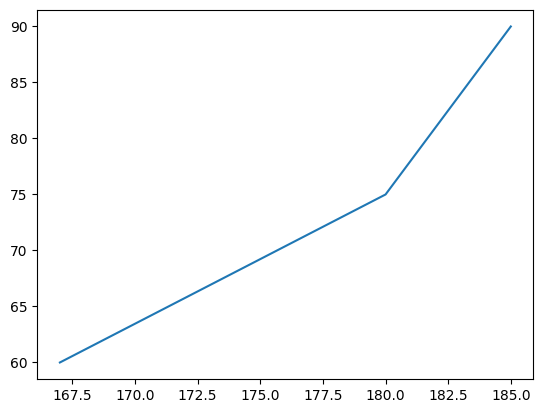

In [8]:
x = [185, 180, 167]
y = [90, 75, 60]
plt.plot(x, y)
plt.show()

Jeśli dodamy inny wymiar o nazwie wiek do tego samego zbioru danych, stanie się on zbiorem danych trójwymiarowych, a wszelkie obserwacje będą znajdować się w przestrzeni trójwymiarowej.

<table>
<thead>
  <tr>
    <th>wzrost</th>
    <th>waga</th>
    <th>wiek</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>185</td>
    <td>90</td>
    <td>23</td>
  </tr>
  <tr>
    <td>180</td>
    <td>75</td>
    <td>53</td>
  </tr>
  <tr>
    <td>167</td>
    <td>60</td>
    <td>28</td>
  </tr>
</tbody>
</table>

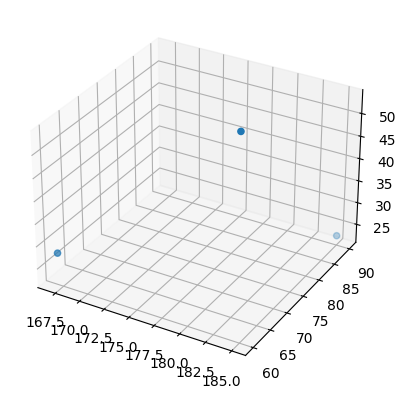

In [9]:
z = [23, 53, 28]

ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, cmap='Greens');

Podobnie zbiory danych ze świata rzeczywistego mają wiele atrybutów. Obserwacje tych zbiorów danych są osadzone w przestrzeni wielowymiarowej, którą trudno sobie wyobrazić. Poniżej przedstawiono ogólną interpretację geometryczną zbioru danych związanego z wymiarowością rozważaną przez naukowców zajmujących się danymi, statystyków i inżynierów uczenia maszynowego.

> W tabelarycznym zestawie danych zawierającym wiersze i kolumny kolumny reprezentują wymiary n-wymiarowej przestrzeni funkcji, a wiersze są punktami danych leżącymi w tej przestrzeni.

Tytułowa redukcja wymiarowości odnosi się po prostu do procesu zmniejszania liczby atrybutów w zbiorze danych przy jednoczesnym zachowaniu jak największej zmienności oryginalnego zbioru danych. Jest to etap wstępnego przetwarzania danych, co oznacza, że przed uczeniem modelu wykonujemy redukcję wymiarowości. Drugim bardzo ważnym zastosowaniem tych metod jest wizualizacja wektorów cech. Notatnik ten skupi się nad przykładami tego drugiego zastosowania. 

W tym notatniku omówione zostaną popularne metody redukcji wymiarowości cech takie jak:


1.   [PCA](#pca) (Principal Component Analysis)
2.   [ICA](#ica) (Independent Component Analysis) 
3.   [NMF](#nmf) (Non-negative Matrix Factorization) 
4.   [t-SNE](#tsne) (t-distributed Stochastic Neighbor Embedding)

<a name="pca"></a>
## PCA (Principal Component Analysis) [link](https://en.wikipedia.org/wiki/Principal_component_analysis)

Czym jest analiza głównych składowych?

Analiza składowych głównych (PCA) to najbardziej popularny algorytm redukcji wymiarów. W ogólnym skrócie polega on na rzutowaniu danych do przestrzeni o mniejszej liczbie wymiarów tak, aby jak najlepiej zachować strukturę danych.

Służy głównie do redukcji zmiennych opisujących dane zjawisko oraz odkrycia ewentualnych prawidłowości między cechami. Dokładna analiza składowych głównych umożliwia wskazanie tych zmiennych początkowych, które mają duży wpływ na wygląd poszczególnych składowych głównych czyli tych, które tworzą grupę jednorodną.

Idea głównych składowych
Analiza PCA opiera się o wyznaczanie osi zachowującej największą wartość wariancji zbioru uczącego. Składowe wyznaczamy jako kombinacje liniową badanych zmiennych.


### PCA -przykład

Do tego przykładu wykorzystamy część zbioru MNIST.

In [10]:
mnist = fetch_openml('mnist_784')

In [11]:
number_of_samples = 1000
images = mnist.data[:number_of_samples].to_numpy()
targets = mnist.target[:number_of_samples] 

In [12]:
print("Kształt wektora zbioru danych:" + str(images.shape))

Kształt wektora zbioru danych:(1000, 784)


Wizualizacja pierwszych 16 przykładów ze zbioru:

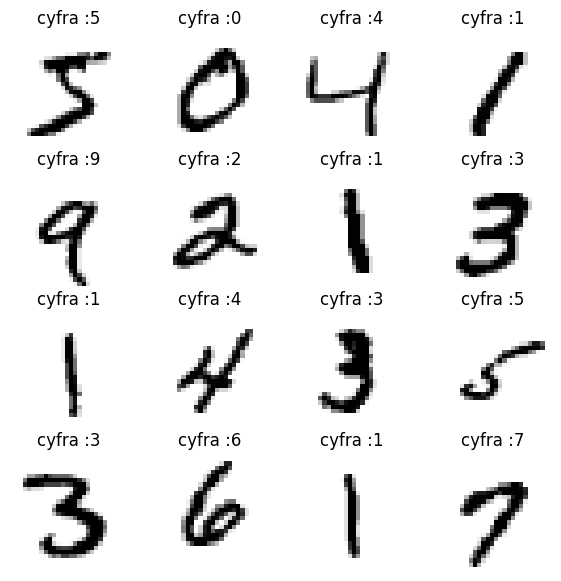

In [13]:
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title("cyfra :" + str(mnist.target[i]))
    plt.axis('off')
    plt.imshow(images[i].reshape(28, 28), cmap='gray_r')

W całym zbiorze jest 70000 przykładów cyfr od 0 do 9. Każdy z obrazów ma rozdzielczość 28x28 pikseli.

Spróbujmy za pomocą metody HoG wydobyć dla pierwszych 1000 przykładów wektor cech z każdego obrazu. 

In [14]:
digit_features = []
hog_images = []

for i in range(0, number_of_samples):
  img = images[i].reshape(28, 28)
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
  digit_features.append(fd)
  hog_images.append(hog_image)

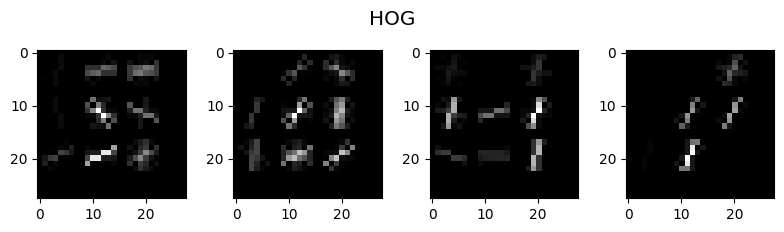

In [15]:
display_images_in_row(hog_images[:4], "HOG", figsize=(8, 8))

Sprawdźmy jaki jest rozmiar pojedynczego wektora cech:

In [16]:
print('Rozmiar: ' + str(digit_features[0].shape))
print('Wektor: ')
print(digit_features[0])

Rozmiar: (72,)
Wektor: 
[0.71448308 0.         0.69965272 0.         0.         0.
 0.         0.         0.         0.29642402 0.55140209 0.55140209
 0.55140209 0.         0.         0.         0.1350893  0.19592877
 0.47360635 0.47360635 0.47360635 0.47360635 0.         0.21482762
 0.28136814 0.         0.         0.         0.         0.
 0.         0.9595999  0.26845251 0.37201602 0.01664263 0.14439069
 0.49041922 0.49041922 0.49041922 0.21651479 0.55795058 0.
 0.         0.25704754 0.55795058 0.55795058 0.         0.
 0.13560368 0.54061863 0.57312705 0.57312705 0.17998307 0.
 0.         0.         0.         0.         0.64060416 0.64060416
 0.40300136 0.1297787  0.         0.         0.40896376 0.28067177
 0.40896376 0.40896376 0.06226099 0.40450536 0.29106169 0.40896376]


Jak widać algorytm HoG wyodrębnił dla każdego z obrazu cyfry 72 elementowy wektor cech. Jest to spora oszczędność w porównaniu z oryginałem, który miał 784 elementy (28px x 28px).

**<font color='red'>!</font> Pamiętaj, aby przed użyciem PCA przeskalować dane w zakresie od 0 do 1!**

In [17]:
scaler = StandardScaler()
scaler.fit(digit_features) 
digit_features_scaled = scaler.transform(digit_features)

Poniżej używamy już gotowej funkcji z pakietu sklearn. Jednym z parametrów konstruktora obiektu PCA jest:

**n_components** – liczba n czynników w nowej przestrzeni

Jest to parametr, który odpowiada do jakiej wielkości przestrzeni chcemy zredukować dane wejściowe. W naszym przypadku sprawdzimy jak będą się wizualizować dane w dwu oraz trzy elementowej przestrzeni. 

Sposób na dobranie odpowiedniej wartości tego parametru zostanie przedstawiony później. 

In [18]:
pca2D = PCA(n_components=2)
pca2D.fit(digit_features_scaled) 
digit_features_pca2D = pca2D.transform(digit_features_scaled) 

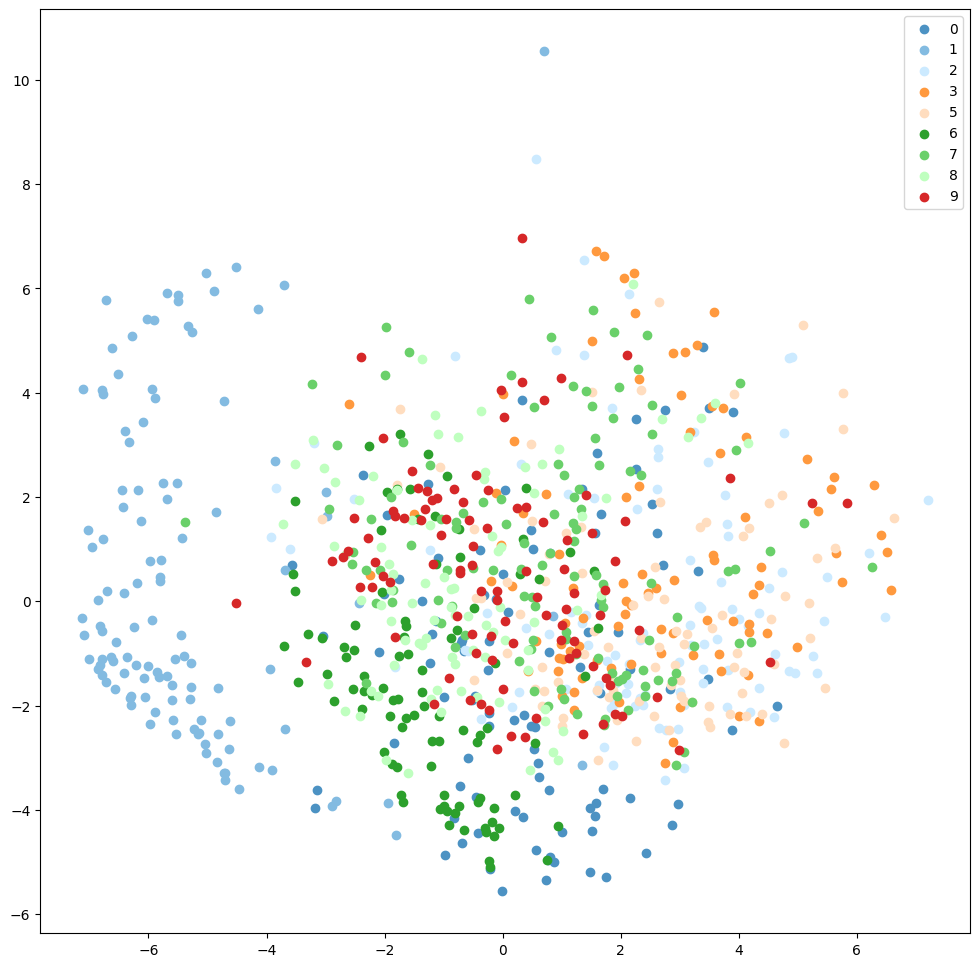

In [19]:
plot_embeddings_2D(digit_features_pca2D, targets, colors_map)

In [20]:
pca3D = PCA(n_components=3)
pca3D.fit(digit_features_scaled) 
digit_features_pca3D = pca3D.transform(digit_features_scaled) 

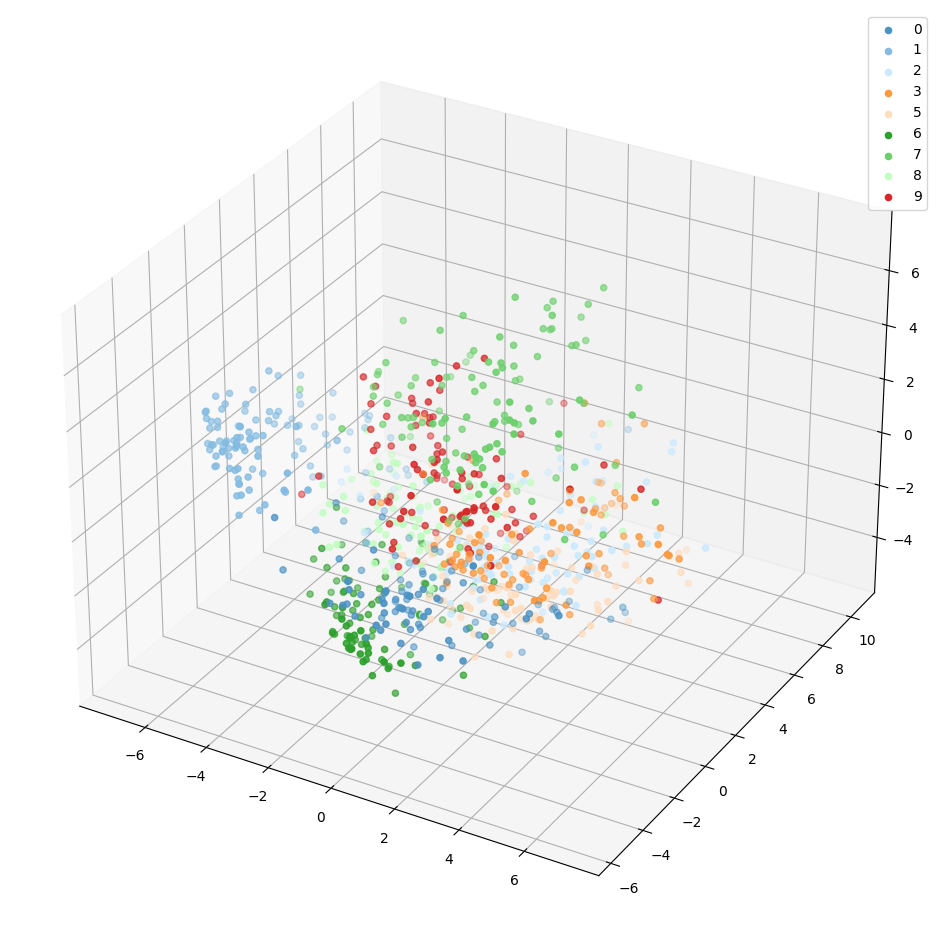

In [21]:
plot_embeddings_3D(digit_features_pca3D, targets, colors_map)

**Komentarz do dwóch wcześniejszych wizualizacji!**

**Jak można dobrać liczbę komponentów?*

Pierwszym ze sposób jest wizualizacja skumulowanej wartości wariancji w zależności od liczby komponentów. Z wykresu można odczytać, że 4 pierwszych czynników może wyjaśnić około 40% całkowitej wariancji.

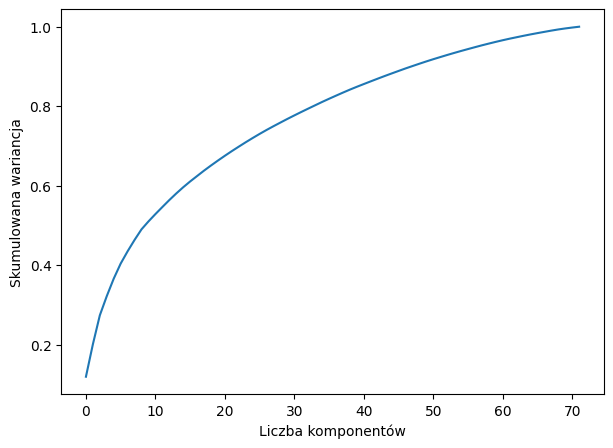

In [22]:
pca = PCA().fit(digit_features_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wariancja')
plt.gcf().set_size_inches(7, 5)

### Ćwiczenie 1.1

Zastosuj algorytm PCA dla oryginalnych obrazów ze zbioru MNIST, przeprowadź analize jaka ilość komponentów byłaby najlepsza by uzyskać wariancję na poziomie 80%. Przeprowadź redukcję wymiarowości do przestrzeni 2D oraz 3D i wyświetl wyniki.  

**Pytania:**
1. Które z podejść pozwala na lepszą separacje danych w widokach 2D oraz 3D? 
2. Jaka ilość komponentów pozwala na uzyskanie wariancji na poziomie 80%?

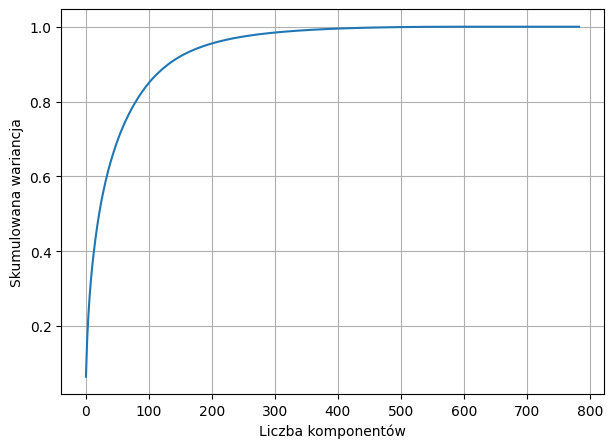

In [23]:
#Miejsce na rozwiązanie zadania
#skalowanie
scaler.fit(images) 
images_scaled = scaler.transform(images)

pca = PCA().fit(images_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wariancja')
plt.grid()
plt.gcf().set_size_inches(7, 5)

<a name="ica"></a>
## ICA (Independent Component Analysis) [link](https://en.wikipedia.org/wiki/Independent_component_analysis)

Independent Component Analysis (ICA) to metoda analizy sygnałów, która polega na dekompozycji sygnału wielowymiarowego na niezależne składowe. W ramach tej metody, poszukiwane są takie niezależne składowe, które odpowiadają za różne aspekty sygnału i które mogą zostać wykorzystane do jego odtworzenia. ICA jest szczególnie przydatna w analizie danych złożonych, takich jak obrazy, dźwięki czy dane finansowe, gdzie poszukiwanie niezależnych składowych może pomóc w identyfikacji istotnych wzorców i zależności. Metoda ta znajduje zastosowanie w wielu dziedzinach, w tym w analizie danych biomedycznych, przetwarzaniu sygnałów audio i wideo, czy analizie finansowej.

Independent Component Analysis (ICA) to metoda analizy sygnałów, która może być również wykorzystana w dziedzinie przetwarzania obrazów. Jednym z przykładów wykorzystania ICA w tej dziedzinie jest analiza składowych kolorów obrazów RGB.

Aby przeprowadzić analizę składowych kolorów za pomocą ICA w Pythonie, można użyć biblioteki scikit-learn (https://scikit-learn.org/stable/index.html). Poniżej przedstawione zostały kroki do przeprowadzenia takiej analizy na dwóch tysiącach elementów ze zbioru MNIST:

In [ ]:
ica = FastICA(n_components=16)
ica.fit(mnist.data[0:2000])
ica_data = ica.transform(mnist.data[0:2000])

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


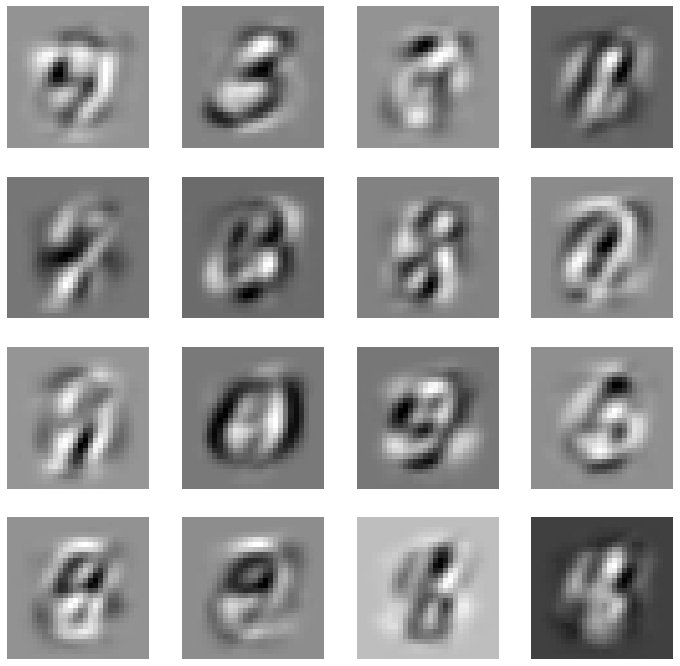

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(ica.components_[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Przykład ten pokazuje, jak wykorzystać ICA w Pythonie do analizy składowych obrazów cyfrowych na przykładzie zbioru danych MNIST. Dzięki temu można uzyskać informacje na temat struktury obrazów i wyróżnić ważne cechy, które mogą być wykorzystane w celach klasyfikacji lub detekcji.

### Ćwiczenie 2.1

Zadanie polega na zastosowaniu metody Independent Component Analysis (ICA) do analizy zbioru danych dotyczącego cyfr pisanych (na przykładzie zbioru danych MNIST) i klasyfikacji ich za pomocą algorytmu SVM (Support Vector Machine).

Kroki:

1.   Załadowanie zbioru danych MNIST oraz jego podział na zbiór treningowy i testowy w proporcji 80/20.
2.   Przeprowadzenie transformacji danych z wykorzystaniem metody ICA w celu wyodrębnienia niezależnych składowych dla 20 komponentów.
3.  Wytrenowanie klasyfikatora SVM na zbiorze treningowym wykorzystując wyodrębnione składowe z kroku 2, liczba epok uczenia to 250. 
4.  Wyliczenie parametru skuteczności na zbiorze testowym.

In [ ]:
#Miejsce na rozwiązanie zadania

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Podział zbioru danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(mnist.data/255, mnist.target, test_size=0.2)

# Wyodrębnienie niezależnych składowych z wykorzystaniem metody ICA
n_components = 20
ica = FastICA(n_components=n_components, random_state=0)
X_train_ica = ica.fit_transform(X_train)
X_test_ica = ica.transform(X_test)

# Wytrenowanie klasyfikatora SVM na zbiorze treningowym
svm = SVC(kernel='rbf', C=10, gamma=0.01, random_state=0, max_iter=250, verbose=True)
svm.fit(X_train_ica, y_train)

# Ocena skuteczności klasyfikatora na zbiorze testowym
y_pred = svm.predict(X_test_ica)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


[LibSVM]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 34.79%



# Przykładowe zagadnienia teoretyczne
1. Jakie są główne różnice pomiędzy metodami PCA i ICA ?
2. Podaj i omów jedną z metody wyznaczania PCA ?
3. Czy możliwe jest storzenie obrazu szaroodcieniowego na podstawie obrazu RGB z wykorzystaniem metod PCA lub ICA ? Wyjaśnij swoją odpowiedź.
4. Czy możliwa jest kompresia obrazu  RGB z wykorzystaniem metod PCA lub ICA ? Wyjaśnij swoją odpowiedź. 

<a name="nmf"></a>
## NMF (Non-negative Matrix Factorization) [link](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

Non-negative Matrix Factorization (NMF) to metoda analizy danych, która polega na faktoryzacji macierzy nieujemnych na dwa czynniki nieujemne. W wyniku tej faktoryzacji otrzymuje się dwie macierze, które są iloczynem dwóch macierzy nieujemnych. NMF jest popularnym podejściem w dziedzinie przetwarzania sygnałów i obrazów, a także w analizie tekstu i innych dziedzinach.

Podobnie jak w przypadku innych metod analizy danych, celem NMF jest redukcja wymiarowości i wyodrębnienie ważnych cech w danych. Metoda ta zakłada, że dane wejściowe są nieujemne, co oznacza, że ​​można je przedstawić jako sumę iloczynów wektorów nieujemnych. NMF jest przydatna w przypadkach, gdy dane wejściowe mają cechy, które są zależne od siebie i trudne do wyodrębnienia w pojedynczych wymiarach.

NMF ma wiele zastosowań, takich jak kompresja danych, rozpoznawanie obrazów, wykrywanie anomalii, rozpoznawanie mówcy, klastrowanie danych i wiele innych.

Zbiór danych MNIST zawiera obrazy cyfr pisanych ręcznie, co czyni go idealnym do zastosowania NMF w dziedzinie obrazów. Poniżej przedstawiony został przykład wykorzystania NMF w języku Python na zbiorze danych MNIST:

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


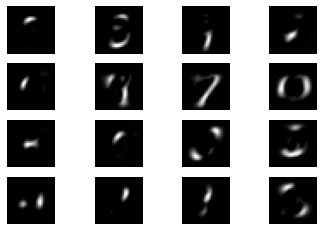

In [ ]:
X = mnist.data.astype('float32')/255.0
y = mnist.target.astype('int')

# redukcja wymiarowości z użyciem NMF
nmf = NMF(n_components=16, init='random', random_state=0)
W = nmf.fit_transform(X)
H = nmf.components_

fig, axes = plt.subplots(4, 4)
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i].reshape(28,28), cmap='gray')
    ax.axis('off')

plt.show()

Powyższy kod normalizuje obrazy ze zbioru MNIST i wykonuje redukcję wymiarowości z użyciem metody NMF. Ustawiono 16 składowych, co oznacza, że ​​obrazy są reprezentowane jako suma 16 wzorców. Następnie z wykorzystaniem biblioteki Matplotlib przedstawione są wzorce, które zostały wykryte przez NMF. Wyniki te można interpretować jako kształty, które często występują w zbiorze danych MNIST.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(W, y, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Dokładność klasyfikacji: ", lr.score(X_test, y_test))

Dokładność klasyfikacji:  0.445


Następnie, w powyższej komórce klasyfikator LogisticRegression jest szkolony na wyjściowych macierzach W, aby określić, czy dany obraz zawiera daną cyfrę. Wyniki klasyfikacji jest wypisany na konsolę.

### Ćwiczenie 3.1

Sprawdzić dla jakiej wartości wzorców wartość skuteczności modelu klasyfikującego jest najlepsza. Eksperyment przeprowadź na zbiorze MNIST na 1000 pierwszych próbek. Przeprowadzić badanie w zakresie 4-16 wzorców. Wyniki wykreślić za pomocą biblioteki Matplotlib.

Dokładność klasyfikacji dla 4 cech: 0.445


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 5 cech: 0.625
Dokładność klasyfikacji dla 6 cech: 0.605
Dokładność klasyfikacji dla 7 cech: 0.655


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 8 cech: 0.69


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 9 cech: 0.665


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 10 cech: 0.715


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 11 cech: 0.775


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 12 cech: 0.755


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 13 cech: 0.775
Dokładność klasyfikacji dla 14 cech: 0.77


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 15 cech: 0.785


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Dokładność klasyfikacji dla 16 cech: 0.79


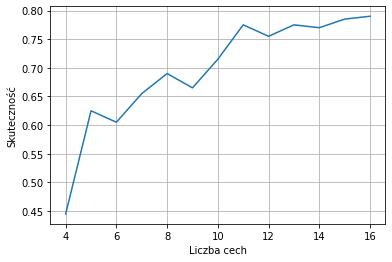

In [ ]:
#Miejsce na rozwiązanie zadania
x = range(4, 17)
results = []
for i in x:
  X = mnist.data[0:1000].astype('float32')/255.0
  y = mnist.target[0:1000].astype('int')
  nmf = NMF(n_components=i, init='random', random_state=0)
  W = nmf.fit_transform(X)
  H = nmf.components_

  X_train, X_test, y_train, y_test = train_test_split(W, y, test_size=0.2, random_state=42)
  lr = LogisticRegression(max_iter=1000)
  lr.fit(X_train, y_train)
  acc = lr.score(X_test, y_test)
  results.append(acc)
  print("Dokładność klasyfikacji dla " + str(i)  + " cech: " + str(acc))

plt.xlabel("Liczba cech")
plt.ylabel("Skuteczność")
plt.plot(x, results)
plt.grid()
plt.show()

<a name="tsne"></a>
## t-SNE (t-distributed Stochastic Neighbor Embedding)

t-SNE (t-distributed Stochastic Neighbor Embedding) to metoda redukcji wymiarowości, która pozwala na wizualizację danych wielowymiarowych w niskowymiarowej przestrzeni. Metoda ta jest szczególnie przydatna w dziedzinie analizy danych i uczenia maszynowego, gdyż umożliwia nam lepsze zrozumienie zależności między różnymi zmiennymi i wzorcami w danych.

Algorytm t-SNE działa poprzez obliczenie podobieństwa między punktami w przestrzeni wielowymiarowej i przekształcenie tych podobieństw na odległości w niskowymiarowej przestrzeni. Algorytm ten wykorzystuje rozkład t-Studenta do określenia prawdopodobieństwa wystąpienia podobieństwa między punktami, co pozwala na uzyskanie bardziej równomiernego rozkładu w przestrzeni niskowymiarowej. Dzięki temu punkty, które są blisko siebie w przestrzeni wielowymiarowej, będą również blisko siebie w przestrzeni niskowymiarowej.

t-SNE jest szczególnie przydatne w przypadku wizualizacji dużych zbiorów danych, ponieważ pozwala na zachowanie jak największej ilości informacji o danych w niskowymiarowej przestrzeni, co pozwala na lepsze zrozumienie zależności między różnymi cechami danych.

Przykładowy kod w języku Python, który wykorzystuje t-SNE do wizualizacji zbioru danych MNIST wygląda następująco:

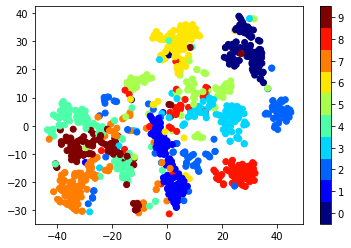

In [ ]:
X = mnist.data.astype('float32')[:1000]
y = mnist.target.astype('int32')[:1000]

# zastosowanie algorytmu t-SNE do redukcji wymiarowości
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# wyświetlenie wyników wizualizacji
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

W tym przykładzie redukujemy jego wymiarowość za pomocą algorytmu t-SNE do 2 wymiarów. Następnie wyświetlamy wyniki wizualizacji za pomocą wykresu punktowego, gdzie każdy punkt reprezentuje jeden obraz z tego zbioru, a jego położenie w przestrzeni niskowymiarowej odpowiada jego cechom. Kolory punktów odpowiadają klasom obrazów (cyfra od 0 do 9). Dzięki tej wizualizacji można łatwo zauważyć, że podobne cyfry są ze sobą blisko, a różne cyfry oddalone są od siebie.

# Przykładowe zagadnienia teoretyczne
1. Jakie są główne różnice pomiędzy metodami NMF i PCA ?
2. Na jakiej podstawie wyznaczana jest odległość między punktami w przestrzeni wielowymiarowej w metodzie t-SNE ?

### Ćwiczenie 4.1

W ćwiczeniu wykorzystany będzie zbiór danych Iris to jeden z najpopularniejszych i najczęściej używanych zbiorów danych w analizie danych i uczeniu maszynowym. Zawiera on informacje na temat trzech gatunków irysów: Iris setosa, Iris versicolor i Iris virginica. Zbiór danych składa się z 150 próbek, z których każda zawiera pomiary długości i szerokości płatków oraz działek kielicha. Zbiór danych Iris jest często wykorzystywany jako przykład w analizie i uczeniu maszynowym, ze względu na swoją prostotę oraz łatwość interpretacji wyników.

Celem ćwiczenia jest wykorzystanie algorytmu t-SNE do wizualizacji zbioru danych Iris. Należy przeprowadzić redukcję wymiarowości zbioru Iris do 2 cech, a następnie zwizualizować klastry klas na płaszczyźnie 2D, uwzględniając etykiety klas. 

Pytania:



/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


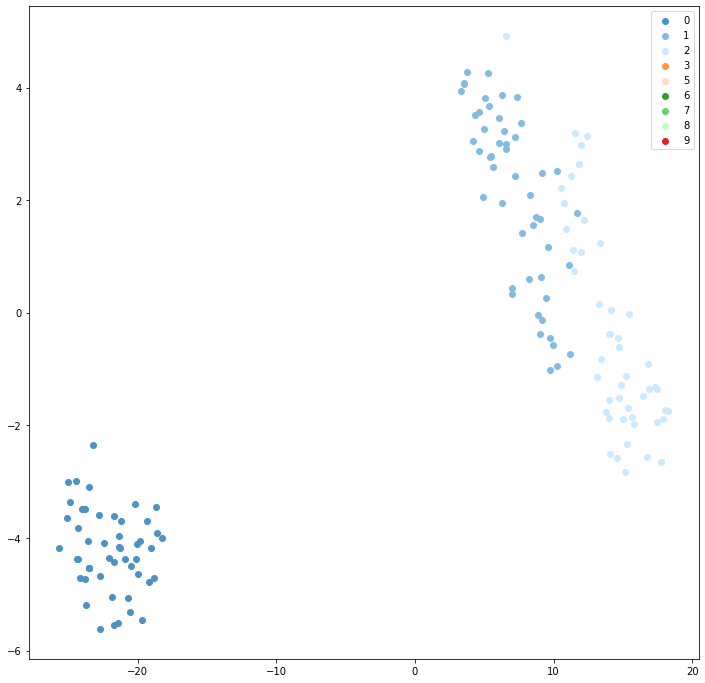

In [ ]:
#Miejsce na rozwiązanie zadania
from sklearn import preprocessing

iris = fetch_openml('iris')
X = iris.data.astype('float32')/255.0
le = preprocessing.LabelEncoder()
le.fit(iris.target)
y = le.transform(iris.target)

# zastosowanie algorytmu t-SNE do redukcji wymiarowości
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# wyświetlenie wyników wizualizacji
plot_embeddings_2D(X_tsne, y, colors_map)

© copyright 2022: Daniel Mostowski, Politechnika Warszawska
(Jupyter notebook adresowany dla studentów: ASO)                                                                                             